In [2]:
import random
random.seed(112358)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.model_selection import GridSearchCV
from random import randint 

from sklearn import tree
%matplotlib inline

from pandas.plotting import scatter_matrix

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

from sklearn.utils import shuffle

import tensorflow as tf

In [47]:
# read in all songs
songs_df = pd.read_csv('data/songs_all_decade_clean.csv')
songs_df.head()

,Artist,Track Name,Track ID,Popularity,Acousticness,Danceability,Duration_ms,Energy,Instrumentalness,Key,Liveness,Loudness,Mode,Speechiness,Tempo,Time Signature,Valence
0,John Lennon,Happy Xmas (War Is Over) - Remastered,3zJw3rugfpVrmBeDDnUYzy,85,0.31900,0.328,213880.0,0.607,0.0,2.0,0.7650,-11.076,1.0,0.0315,146.539,3.0,0.395
1,Bruno Mars,Just the Way You Are,7BqBn9nzAq8spo5e7cZ0dJ,81,0.01510,0.637,220733.0,0.843,0.0,5.0,0.0876,-5.413,1.0,0.0432,109.012,4.0,0.434
2,Train,"Hey, Soul Sister",4HlFJV71xXKIGcU3kRyttv,83,0.18500,0.673,216773.0,0.886,0.0,1.0,0.0826,-4.440,0.0,0.0431,97.012,4.0,0.795
3,Waka Flocka Flame,No Hands (feat. Roscoe Dash & Wale),03tqyYWC9Um2ZqU0ZN849H,75,0.00544,0.760,263773.0,0.595,0.0,1.0,0.2410,-6.366,1.0,0.0391,131.497,4.0,0.361
4,Kanye West,POWER,2gZUPNdnz5Y45eiGxpHGSc,79,0.01620,0.543,292093.0,0.915,0.0,0.0,0.7440,-4.746,0.0,0.1130,153.998,4.0,0.577


In [5]:
# calculate summary statistics
display(songs_df.describe())

# print out variable types
print(songs_df.dtypes)

,Popularity,Acousticness,Danceability,Duration_ms,Energy,Instrumentalness,Key,Liveness,Loudness,Mode,Speechiness,Tempo,Time Signature,Valence
count,88554.000000,88554.000000,88554.000000,88554.000000,88554.000000,88554.000000,88554.000000,88554.000000,88554.000000,88554.000000,88554.000000,88554.000000,88554.000000,88554.000000
mean,49.006708,0.311873,0.577886,220548.322538,0.600973,0.135175,5.203255,0.189423,-8.324528,0.652991,0.095061,120.630076,3.896662,0.449532
std,13.237356,0.330381,0.176493,68945.507097,0.249771,0.297049,3.589677,0.156954,5.528754,0.476021,0.098324,30.252905,0.431127,0.249264
min,0.000000,0.000000,0.053200,20139.000000,0.000020,0.000000,0.000000,0.009360,-54.837000,0.000000,0.022400,33.506000,0.000000,0.000000
25%,41.000000,0.026600,0.465000,182866.250000,0.444000,0.000000,2.000000,0.097600,-9.510000,0.000000,0.036400,96.032000,4.000000,0.247000
50%,49.000000,0.170000,0.590000,214293.000000,0.638000,0.000010,5.000000,0.124000,-6.737000,1.000000,0.051300,120.014000,4.000000,0.429000
75%,57.000000,0.557000,0.709000,249997.750000,0.800000,0.011300,8.000000,0.231000,-4.987000,1.000000,0.105000,140.052000,4.000000,0.637000
max,100.000000,0.996000,0.987000,599746.000000,1.000000,1.000000,11.000000,0.998000,1.593000,1.000000,0.659000,220.169000,5.000000,1.000000


Artist               object
Track Name           object
Track ID             object
Popularity            int64
Acousticness        float64
Danceability        float64
Duration_ms         float64
Energy              float64
Instrumentalness    float64
Key                 float64
Liveness            float64
Loudness            float64
Mode                float64
Speechiness         float64
Tempo               float64
Time Signature      float64
Valence             float64
dtype: object


In [ ]:
# matrix of pairwise scatterplots
scatter_matrix(songs_df, alpha = 0.8, figsize = (30, 20), diagonal = 'kde')

In [48]:
# create new binary response variable 'tophit'
# classify as top hit if popularity > 60 (about halfway split)
songs_df['tophit'] = np.where(songs_df['Popularity'] > 60, 1, 0)

In [49]:
# prepare for modeling
songs_df_clean = songs_df.drop(columns = ['Artist', 'Track Name', 'Track ID', 'Popularity'])

X_train, X_test, y_train, y_test = train_test_split(songs_df_clean.loc[:, songs_df_clean.columns != 'tophit'], 
                                                    songs_df_clean.tophit, test_size = 0.2, 
                                                    random_state = 100, stratify = songs_df_clean.tophit)

In [6]:
# fit cross-validated single decision tree
depths = list(range(1, 21))

def calc_meanstd(X_train, y_train, depths):
    cvmeans = {}
    cvstds = {}
    train_scores = {}
    for i in depths:
        model = DecisionTreeClassifier(max_depth = i)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_train)
        # get training set scores
        train_scores[i] = accuracy_score(y_train, y_pred)
        # get cross-validation scores
        score = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5, n_jobs = -1)
        cvmeans[i] = score.mean()
        cvstds[i] = score.std()
    return cvmeans, cvstds, train_scores

cvmeans, cvstds, train_scores = calc_meanstd(X_train, y_train, depths)

In [9]:
# report best tree depth from cross-validation
best_depth = sorted(cvmeans, key = cvmeans.get, reverse = True)[0]
print('Best depth:', best_depth)

# refit on best tree depth, then report classification accuracies
best_model = DecisionTreeClassifier(max_depth = best_depth)
best_model.fit(X_train, y_train)

y_train_pred = best_model.predict(X_train)
best_cv_tree_train_score = accuracy_score(y_train, y_train_pred)
print('Classification accuracy on training set:', best_cv_tree_train_score)

y_test_pred = best_model.predict(X_test)
best_cv_tree_test_score = accuracy_score(y_test, y_test_pred)
print('Classification accuracy on test set:', best_cv_tree_test_score)

Best depth: 3
Classification accuracy on training set: 0.645
Classification accuracy on test set: 0.6395


In [50]:
cat_cols = ['Key', 'Time Signature', 'Mode']
X_train_num = X_train.drop(cat_cols, axis = 1)
X_test_num = X_test.drop(cat_cols, axis = 1)
num_features = X_train_num.columns.tolist()
num_index_train = X_train.index.tolist()
num_index_test = X_test.index.tolist()

# X_train_dum = pd.get_dummies(X_train[cat_cols], columns = cat_cols)
# X_test_dum = pd.get_dummies(X_test[cat_cols], columns = cat_cols)
X_train_dum = X_train[cat_cols]
X_test_dum = X_test[cat_cols]

scaler = StandardScaler().fit(X_train_num)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_num), index = num_index_train, columns = num_features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_num), index = num_index_test, columns = num_features)

X_train = pd.concat([X_train_dum, X_train_scaled], axis = 1)
X_test = pd.concat([X_test_dum, X_test_scaled], axis = 1)

In [12]:
X_train.head()

,Key,Time Signature,Mode,Acousticness,Danceability,Duration_ms,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Valence
42751,1.0,4.0,1.0,-0.943781,-0.726754,0.477700,1.501201,-0.453331,-0.268879,0.665365,1.218310,0.636980,-0.728170
34498,1.0,3.0,1.0,1.898434,-2.211738,0.149377,-1.905981,-0.435899,-0.428016,-0.875771,-0.523018,1.962243,-1.337873
23353,2.0,3.0,1.0,-0.802075,-1.049823,-0.699669,0.855841,-0.452488,-0.237052,0.549816,2.427988,2.026887,-0.952797
34136,8.0,3.0,1.0,0.865138,0.684547,-0.011866,-1.376866,-0.453668,-0.603703,-0.354985,-0.558597,-0.291994,-0.278914
79175,4.0,4.0,1.0,0.443941,0.412489,0.235791,0.366810,-0.453668,0.927829,0.650854,-0.586043,-0.057313,-0.230780


In [56]:
# specify network layers
binary_ann_overfit = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (13, )),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# compile and fit network
binary_ann_overfit.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) 
history = binary_ann_overfit.fit(X_train, y_train, epochs = 1000, batch_size = 128, validation_split = 0.3)

Train on 49590 samples, validate on 21253 samples
Epoch 1/1000
49590/49590 [==============================] - 2s 40us/sample - loss: 0.4481 - accuracy: 0.8224 - val_loss: 0.4404 - val_accuracy: 0.8233
Epoch 2/1000
49590/49590 [==============================] - 2s 36us/sample - loss: 0.4314 - accuracy: 0.8267 - val_loss: 0.4388 - val_accuracy: 0.8233
Epoch 3/1000
49590/49590 [==============================] - 2s 38us/sample - loss: 0.4274 - accuracy: 0.8268 - val_loss: 0.4365 - val_accuracy: 0.8233
Epoch 4/1000
49590/49590 [==============================] - 2s 35us/sample - loss: 0.4254 - accuracy: 0.8266 - val_loss: 0.4382 - val_accuracy: 0.8234
Epoch 5/1000
49590/49590 [==============================] - 2s 31us/sample - loss: 0.4238 - accuracy: 0.8266 - val_loss: 0.4379 - val_accuracy: 0.8228
Epoch 6/1000
49590/49590 [==============================] - 2s 32us/sample - loss: 0.4223 - accuracy: 0.8267 - val_loss: 0.4344 - val_accuracy: 0.8236
Epoch 7/1000
49590/49590 [==================

Epoch 107/1000
49590/49590 [==============================] - 1s 27us/sample - loss: 0.1788 - accuracy: 0.9250 - val_loss: 1.0403 - val_accuracy: 0.7648
Epoch 108/1000
49590/49590 [==============================] - 1s 28us/sample - loss: 0.1817 - accuracy: 0.9240 - val_loss: 1.0278 - val_accuracy: 0.7570
Epoch 109/1000
49590/49590 [==============================] - 1s 27us/sample - loss: 0.1774 - accuracy: 0.9251 - val_loss: 1.0285 - val_accuracy: 0.7554
Epoch 110/1000
49590/49590 [==============================] - 1s 27us/sample - loss: 0.1778 - accuracy: 0.9262 - val_loss: 1.0431 - val_accuracy: 0.7619
Epoch 111/1000
49590/49590 [==============================] - 1s 28us/sample - loss: 0.1761 - accuracy: 0.9263 - val_loss: 1.0296 - val_accuracy: 0.7545
Epoch 112/1000
49590/49590 [==============================] - 1s 28us/sample - loss: 0.1776 - accuracy: 0.9253 - val_loss: 1.0679 - val_accuracy: 0.7423
Epoch 113/1000
49590/49590 [==============================] - 1s 27us/sample - los

49590/49590 [==============================] - 2s 31us/sample - loss: 0.1011 - accuracy: 0.9596 - val_loss: 1.5859 - val_accuracy: 0.7487
Epoch 214/1000
49590/49590 [==============================] - 1s 30us/sample - loss: 0.0956 - accuracy: 0.9633 - val_loss: 1.5978 - val_accuracy: 0.7369
Epoch 215/1000
49590/49590 [==============================] - 2s 31us/sample - loss: 0.1020 - accuracy: 0.9615 - val_loss: 1.6081 - val_accuracy: 0.7463
Epoch 216/1000
49590/49590 [==============================] - 2s 31us/sample - loss: 0.1113 - accuracy: 0.9568 - val_loss: 1.6040 - val_accuracy: 0.7462
Epoch 217/1000
49590/49590 [==============================] - 2s 31us/sample - loss: 0.1033 - accuracy: 0.9597 - val_loss: 1.6015 - val_accuracy: 0.7373
Epoch 218/1000
49590/49590 [==============================] - 2s 34us/sample - loss: 0.1038 - accuracy: 0.9589 - val_loss: 1.6217 - val_accuracy: 0.7391
Epoch 219/1000
49590/49590 [==============================] - 1s 28us/sample - loss: 0.0998 - acc

49590/49590 [==============================] - 2s 42us/sample - loss: 0.0802 - accuracy: 0.9699 - val_loss: 1.8893 - val_accuracy: 0.7384
Epoch 320/1000
49590/49590 [==============================] - 2s 34us/sample - loss: 0.0903 - accuracy: 0.9669 - val_loss: 1.8698 - val_accuracy: 0.7409
Epoch 321/1000
49590/49590 [==============================] - 2s 36us/sample - loss: 0.0735 - accuracy: 0.9721 - val_loss: 1.9102 - val_accuracy: 0.7291
Epoch 322/1000
49590/49590 [==============================] - 2s 32us/sample - loss: 0.0795 - accuracy: 0.9704 - val_loss: 1.8591 - val_accuracy: 0.7506
Epoch 323/1000
49590/49590 [==============================] - 2s 32us/sample - loss: 0.0784 - accuracy: 0.9719 - val_loss: 1.8734 - val_accuracy: 0.7433
Epoch 324/1000
49590/49590 [==============================] - 2s 31us/sample - loss: 0.0905 - accuracy: 0.9667 - val_loss: 1.8806 - val_accuracy: 0.7490
Epoch 325/1000
49590/49590 [==============================] - 2s 32us/sample - loss: 0.0940 - acc

49590/49590 [==============================] - 2s 39us/sample - loss: 0.0643 - accuracy: 0.9776 - val_loss: 2.0234 - val_accuracy: 0.7457
Epoch 426/1000
49590/49590 [==============================] - 2s 38us/sample - loss: 0.0800 - accuracy: 0.9711 - val_loss: 2.0249 - val_accuracy: 0.7390
Epoch 427/1000
49590/49590 [==============================] - 2s 39us/sample - loss: 0.0610 - accuracy: 0.9782 - val_loss: 2.0425 - val_accuracy: 0.7405
Epoch 428/1000
49590/49590 [==============================] - 2s 44us/sample - loss: 0.0527 - accuracy: 0.9813 - val_loss: 2.0324 - val_accuracy: 0.7401
Epoch 429/1000
49590/49590 [==============================] - 2s 41us/sample - loss: 0.0725 - accuracy: 0.9741 - val_loss: 2.0338 - val_accuracy: 0.7391
Epoch 430/1000
49590/49590 [==============================] - 2s 38us/sample - loss: 0.0674 - accuracy: 0.9765 - val_loss: 2.0090 - val_accuracy: 0.7438
Epoch 431/1000
49590/49590 [==============================] - 2s 41us/sample - loss: 0.0661 - acc

49590/49590 [==============================] - 2s 31us/sample - loss: 0.0637 - accuracy: 0.9770 - val_loss: 2.0842 - val_accuracy: 0.7480
Epoch 532/1000
49590/49590 [==============================] - 1s 30us/sample - loss: 0.0578 - accuracy: 0.9804 - val_loss: 2.0828 - val_accuracy: 0.7412
Epoch 533/1000
49590/49590 [==============================] - 2s 30us/sample - loss: 0.0492 - accuracy: 0.9836 - val_loss: 2.1125 - val_accuracy: 0.7390
Epoch 534/1000
49590/49590 [==============================] - 2s 30us/sample - loss: 0.0596 - accuracy: 0.9797 - val_loss: 2.1154 - val_accuracy: 0.7422
Epoch 535/1000
49590/49590 [==============================] - 1s 30us/sample - loss: 0.0713 - accuracy: 0.9750 - val_loss: 2.0710 - val_accuracy: 0.7506
Epoch 536/1000
49590/49590 [==============================] - 2s 33us/sample - loss: 0.0626 - accuracy: 0.9785 - val_loss: 2.1122 - val_accuracy: 0.7331
Epoch 537/1000
49590/49590 [==============================] - 2s 35us/sample - loss: 0.0533 - acc

49590/49590 [==============================] - 2s 31us/sample - loss: 0.0404 - accuracy: 0.9855 - val_loss: 2.1342 - val_accuracy: 0.7457
Epoch 638/1000
49590/49590 [==============================] - 2s 33us/sample - loss: 0.0453 - accuracy: 0.9844 - val_loss: 2.1403 - val_accuracy: 0.7453
Epoch 639/1000
49590/49590 [==============================] - 2s 32us/sample - loss: 0.0510 - accuracy: 0.9817 - val_loss: 2.1612 - val_accuracy: 0.7417
Epoch 640/1000
49590/49590 [==============================] - 2s 37us/sample - loss: 0.0524 - accuracy: 0.9823 - val_loss: 2.1396 - val_accuracy: 0.7431
Epoch 641/1000
49590/49590 [==============================] - 2s 32us/sample - loss: 0.0573 - accuracy: 0.9800 - val_loss: 2.1523 - val_accuracy: 0.7445
Epoch 642/1000
49590/49590 [==============================] - 2s 34us/sample - loss: 0.0494 - accuracy: 0.9829 - val_loss: 2.1814 - val_accuracy: 0.7377
Epoch 643/1000
49590/49590 [==============================] - 2s 32us/sample - loss: 0.0466 - acc

49590/49590 [==============================] - 1s 27us/sample - loss: 0.0493 - accuracy: 0.9825 - val_loss: 2.2014 - val_accuracy: 0.7355
Epoch 744/1000
49590/49590 [==============================] - 1s 28us/sample - loss: 0.0424 - accuracy: 0.9861 - val_loss: 2.1631 - val_accuracy: 0.7484
Epoch 745/1000
49590/49590 [==============================] - 1s 27us/sample - loss: 0.0418 - accuracy: 0.9853 - val_loss: 2.1978 - val_accuracy: 0.7426
Epoch 746/1000
49590/49590 [==============================] - 1s 27us/sample - loss: 0.0428 - accuracy: 0.9851 - val_loss: 2.2137 - val_accuracy: 0.7390
Epoch 747/1000
49590/49590 [==============================] - 1s 27us/sample - loss: 0.0450 - accuracy: 0.9842 - val_loss: 2.1617 - val_accuracy: 0.7483
Epoch 748/1000
49590/49590 [==============================] - 1s 27us/sample - loss: 0.0492 - accuracy: 0.9834 - val_loss: 2.1776 - val_accuracy: 0.7437
Epoch 749/1000
49590/49590 [==============================] - 1s 28us/sample - loss: 0.0491 - acc

49590/49590 [==============================] - 2s 31us/sample - loss: 0.0436 - accuracy: 0.9849 - val_loss: 2.2004 - val_accuracy: 0.7478
Epoch 850/1000
49590/49590 [==============================] - 2s 31us/sample - loss: 0.0397 - accuracy: 0.9856 - val_loss: 2.2271 - val_accuracy: 0.7389
Epoch 851/1000
49590/49590 [==============================] - 1s 30us/sample - loss: 0.0344 - accuracy: 0.9880 - val_loss: 2.2028 - val_accuracy: 0.7484
Epoch 852/1000
49590/49590 [==============================] - 2s 30us/sample - loss: 0.0425 - accuracy: 0.9849 - val_loss: 2.2290 - val_accuracy: 0.7455
Epoch 853/1000
49590/49590 [==============================] - 2s 31us/sample - loss: 0.0692 - accuracy: 0.9777 - val_loss: 2.2493 - val_accuracy: 0.7336
Epoch 854/1000
49590/49590 [==============================] - 2s 31us/sample - loss: 0.0519 - accuracy: 0.9829 - val_loss: 2.1880 - val_accuracy: 0.7436
Epoch 855/1000
49590/49590 [==============================] - 1s 30us/sample - loss: 0.0367 - acc

49590/49590 [==============================] - 1s 28us/sample - loss: 0.0407 - accuracy: 0.9858 - val_loss: 2.2085 - val_accuracy: 0.7557
Epoch 956/1000
49590/49590 [==============================] - 1s 28us/sample - loss: 0.0485 - accuracy: 0.9840 - val_loss: 2.2403 - val_accuracy: 0.7395
Epoch 957/1000
49590/49590 [==============================] - 1s 27us/sample - loss: 0.0447 - accuracy: 0.9852 - val_loss: 2.2124 - val_accuracy: 0.7520
Epoch 958/1000
49590/49590 [==============================] - 1s 28us/sample - loss: 0.0357 - accuracy: 0.9878 - val_loss: 2.1868 - val_accuracy: 0.7535
Epoch 959/1000
49590/49590 [==============================] - 1s 28us/sample - loss: 0.0420 - accuracy: 0.9860 - val_loss: 2.2271 - val_accuracy: 0.7428
Epoch 960/1000
49590/49590 [==============================] - 1s 28us/sample - loss: 0.0369 - accuracy: 0.9873 - val_loss: 2.2194 - val_accuracy: 0.7466
Epoch 961/1000
49590/49590 [==============================] - 1s 27us/sample - loss: 0.0448 - acc

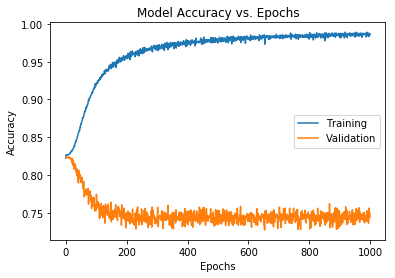

In [59]:
# plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy vs. Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc = 'best')
plt.show()

In [60]:
print(binary_ann_overfit.evaluate(X_train, y_train, verbose=0))
print(binary_ann_overfit.evaluate(X_test, y_test, verbose=0))

[0.6948566506003924, 0.9157715]
[2.185305051145047, 0.75455934]


In [22]:
# address overfitting
binary_ann = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (13, )),
    tf.keras.layers.Dense(100, activation = 'relu', 
                       kernel_regularizer = tf.keras.regularizers.l2(l = 0.001)),
    tf.keras.layers.Dense(100, activation = 'relu', 
                       kernel_regularizer = tf.keras.regularizers.l2(l = 0.001)),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# compile and fit network
binary_ann.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) 
history = binary_ann.fit(X_train, y_train, epochs = 1000, batch_size = 128, validation_split = 0.3)

Train on 49590 samples, validate on 21253 samples
Epoch 1/1000
49590/49590 [==============================] - 2s 36us/sample - loss: 0.5212 - accuracy: 0.8224 - val_loss: 0.4979 - val_accuracy: 0.8229
Epoch 2/1000
49590/49590 [==============================] - 1s 23us/sample - loss: 0.4737 - accuracy: 0.8266 - val_loss: 0.4733 - val_accuracy: 0.8233
Epoch 3/1000
49590/49590 [==============================] - 1s 25us/sample - loss: 0.4589 - accuracy: 0.8267 - val_loss: 0.4624 - val_accuracy: 0.8233
Epoch 4/1000
49590/49590 [==============================] - 1s 28us/sample - loss: 0.4512 - accuracy: 0.8266 - val_loss: 0.4582 - val_accuracy: 0.8230
Epoch 5/1000
49590/49590 [==============================] - 1s 29us/sample - loss: 0.4457 - accuracy: 0.8267 - val_loss: 0.4531 - val_accuracy: 0.8233
Epoch 6/1000
49590/49590 [==============================] - 1s 25us/sample - loss: 0.4420 - accuracy: 0.8267 - val_loss: 0.4510 - val_accuracy: 0.8233
Epoch 7/1000
49590/49590 [==================

Epoch 107/1000
49590/49590 [==============================] - 1s 24us/sample - loss: 0.4252 - accuracy: 0.8268 - val_loss: 0.4384 - val_accuracy: 0.8235
Epoch 108/1000
49590/49590 [==============================] - 1s 23us/sample - loss: 0.4258 - accuracy: 0.8266 - val_loss: 0.4377 - val_accuracy: 0.8238
Epoch 109/1000
49590/49590 [==============================] - 1s 22us/sample - loss: 0.4257 - accuracy: 0.8268 - val_loss: 0.4365 - val_accuracy: 0.8234
Epoch 110/1000
49590/49590 [==============================] - 1s 22us/sample - loss: 0.4250 - accuracy: 0.8269 - val_loss: 0.4380 - val_accuracy: 0.8234
Epoch 111/1000
49590/49590 [==============================] - 1s 22us/sample - loss: 0.4253 - accuracy: 0.8266 - val_loss: 0.4374 - val_accuracy: 0.8236
Epoch 112/1000
49590/49590 [==============================] - 1s 23us/sample - loss: 0.4254 - accuracy: 0.8271 - val_loss: 0.4369 - val_accuracy: 0.8233
Epoch 113/1000
49590/49590 [==============================] - 1s 23us/sample - los

49590/49590 [==============================] - 1s 20us/sample - loss: 0.4244 - accuracy: 0.8267 - val_loss: 0.4361 - val_accuracy: 0.8240
Epoch 214/1000
49590/49590 [==============================] - 1s 20us/sample - loss: 0.4246 - accuracy: 0.8270 - val_loss: 0.4368 - val_accuracy: 0.8237
Epoch 215/1000
49590/49590 [==============================] - 1s 20us/sample - loss: 0.4241 - accuracy: 0.8269 - val_loss: 0.4421 - val_accuracy: 0.8236
Epoch 216/1000
49590/49590 [==============================] - 1s 20us/sample - loss: 0.4243 - accuracy: 0.8269 - val_loss: 0.4395 - val_accuracy: 0.8236
Epoch 217/1000
49590/49590 [==============================] - 1s 20us/sample - loss: 0.4245 - accuracy: 0.8271 - val_loss: 0.4406 - val_accuracy: 0.8236
Epoch 218/1000
49590/49590 [==============================] - 1s 20us/sample - loss: 0.4241 - accuracy: 0.8271 - val_loss: 0.4373 - val_accuracy: 0.8234
Epoch 219/1000
49590/49590 [==============================] - 1s 20us/sample - loss: 0.4241 - acc

49590/49590 [==============================] - 1s 23us/sample - loss: 0.4234 - accuracy: 0.8268 - val_loss: 0.4393 - val_accuracy: 0.8238
Epoch 320/1000
49590/49590 [==============================] - 2s 32us/sample - loss: 0.4236 - accuracy: 0.8265 - val_loss: 0.4371 - val_accuracy: 0.8236
Epoch 321/1000
49590/49590 [==============================] - 1s 27us/sample - loss: 0.4237 - accuracy: 0.8270 - val_loss: 0.4368 - val_accuracy: 0.8235
Epoch 322/1000
49590/49590 [==============================] - 1s 27us/sample - loss: 0.4235 - accuracy: 0.8270 - val_loss: 0.4428 - val_accuracy: 0.8242
Epoch 323/1000
49590/49590 [==============================] - 1s 23us/sample - loss: 0.4235 - accuracy: 0.8271 - val_loss: 0.4384 - val_accuracy: 0.8236
Epoch 324/1000
49590/49590 [==============================] - 1s 22us/sample - loss: 0.4238 - accuracy: 0.8271 - val_loss: 0.4361 - val_accuracy: 0.8236
Epoch 325/1000
49590/49590 [==============================] - 1s 23us/sample - loss: 0.4233 - acc

49590/49590 [==============================] - 1s 23us/sample - loss: 0.4229 - accuracy: 0.8273 - val_loss: 0.4382 - val_accuracy: 0.8233
Epoch 426/1000
49590/49590 [==============================] - 1s 23us/sample - loss: 0.4232 - accuracy: 0.8269 - val_loss: 0.4389 - val_accuracy: 0.8238
Epoch 427/1000
49590/49590 [==============================] - 1s 23us/sample - loss: 0.4233 - accuracy: 0.8266 - val_loss: 0.4372 - val_accuracy: 0.8235
Epoch 428/1000
49590/49590 [==============================] - 1s 23us/sample - loss: 0.4232 - accuracy: 0.8271 - val_loss: 0.4365 - val_accuracy: 0.8234
Epoch 429/1000
49590/49590 [==============================] - 1s 23us/sample - loss: 0.4229 - accuracy: 0.8273 - val_loss: 0.4375 - val_accuracy: 0.8238
Epoch 430/1000
49590/49590 [==============================] - 1s 23us/sample - loss: 0.4229 - accuracy: 0.8270 - val_loss: 0.4373 - val_accuracy: 0.8238
Epoch 431/1000
49590/49590 [==============================] - 1s 23us/sample - loss: 0.4229 - acc

49590/49590 [==============================] - 1s 23us/sample - loss: 0.4228 - accuracy: 0.8272 - val_loss: 0.4367 - val_accuracy: 0.8242
Epoch 532/1000
49590/49590 [==============================] - 1s 23us/sample - loss: 0.4222 - accuracy: 0.8272 - val_loss: 0.4363 - val_accuracy: 0.8242
Epoch 533/1000
49590/49590 [==============================] - 1s 23us/sample - loss: 0.4226 - accuracy: 0.8266 - val_loss: 0.4367 - val_accuracy: 0.8243
Epoch 534/1000
49590/49590 [==============================] - 1s 23us/sample - loss: 0.4224 - accuracy: 0.8272 - val_loss: 0.4432 - val_accuracy: 0.8233
Epoch 535/1000
49590/49590 [==============================] - 1s 22us/sample - loss: 0.4228 - accuracy: 0.8273 - val_loss: 0.4390 - val_accuracy: 0.8235
Epoch 536/1000
49590/49590 [==============================] - 1s 23us/sample - loss: 0.4228 - accuracy: 0.8275 - val_loss: 0.4371 - val_accuracy: 0.8245
Epoch 537/1000
49590/49590 [==============================] - 1s 22us/sample - loss: 0.4226 - acc

49590/49590 [==============================] - 1s 22us/sample - loss: 0.4225 - accuracy: 0.8277 - val_loss: 0.4376 - val_accuracy: 0.8237
Epoch 638/1000
49590/49590 [==============================] - 1s 20us/sample - loss: 0.4225 - accuracy: 0.8273 - val_loss: 0.4360 - val_accuracy: 0.8238
Epoch 639/1000
49590/49590 [==============================] - 1s 20us/sample - loss: 0.4229 - accuracy: 0.8268 - val_loss: 0.4383 - val_accuracy: 0.8242
Epoch 640/1000
49590/49590 [==============================] - 1s 20us/sample - loss: 0.4223 - accuracy: 0.8270 - val_loss: 0.4389 - val_accuracy: 0.8239
Epoch 641/1000
49590/49590 [==============================] - 1s 20us/sample - loss: 0.4222 - accuracy: 0.8269 - val_loss: 0.4381 - val_accuracy: 0.8236
Epoch 642/1000
49590/49590 [==============================] - 1s 20us/sample - loss: 0.4226 - accuracy: 0.8272 - val_loss: 0.4416 - val_accuracy: 0.8206
Epoch 643/1000
49590/49590 [==============================] - 1s 20us/sample - loss: 0.4224 - acc

49590/49590 [==============================] - 2s 38us/sample - loss: 0.4225 - accuracy: 0.8276 - val_loss: 0.4396 - val_accuracy: 0.8231
Epoch 744/1000
49590/49590 [==============================] - 1s 27us/sample - loss: 0.4223 - accuracy: 0.8272 - val_loss: 0.4424 - val_accuracy: 0.8236
Epoch 745/1000
49590/49590 [==============================] - 1s 27us/sample - loss: 0.4224 - accuracy: 0.8275 - val_loss: 0.4371 - val_accuracy: 0.8238
Epoch 746/1000
49590/49590 [==============================] - 1s 28us/sample - loss: 0.4223 - accuracy: 0.8274 - val_loss: 0.4396 - val_accuracy: 0.8234
Epoch 747/1000
49590/49590 [==============================] - 2s 36us/sample - loss: 0.4220 - accuracy: 0.8274 - val_loss: 0.4370 - val_accuracy: 0.8245
Epoch 748/1000
49590/49590 [==============================] - 1s 30us/sample - loss: 0.4217 - accuracy: 0.8272 - val_loss: 0.4419 - val_accuracy: 0.8213
Epoch 749/1000
49590/49590 [==============================] - 2s 37us/sample - loss: 0.4223 - acc

49590/49590 [==============================] - 1s 21us/sample - loss: 0.4216 - accuracy: 0.8274 - val_loss: 0.4377 - val_accuracy: 0.8244
Epoch 850/1000
49590/49590 [==============================] - 1s 20us/sample - loss: 0.4216 - accuracy: 0.8279 - val_loss: 0.4383 - val_accuracy: 0.8231
Epoch 851/1000
49590/49590 [==============================] - 1s 22us/sample - loss: 0.4217 - accuracy: 0.8276 - val_loss: 0.4374 - val_accuracy: 0.8242
Epoch 852/1000
49590/49590 [==============================] - 1s 25us/sample - loss: 0.4219 - accuracy: 0.8273 - val_loss: 0.4426 - val_accuracy: 0.8234
Epoch 853/1000
49590/49590 [==============================] - 1s 22us/sample - loss: 0.4217 - accuracy: 0.8270 - val_loss: 0.4407 - val_accuracy: 0.8240
Epoch 854/1000
49590/49590 [==============================] - 1s 25us/sample - loss: 0.4219 - accuracy: 0.8271 - val_loss: 0.4369 - val_accuracy: 0.8233
Epoch 855/1000
49590/49590 [==============================] - 1s 21us/sample - loss: 0.4219 - acc

49590/49590 [==============================] - 1s 27us/sample - loss: 0.4215 - accuracy: 0.8279 - val_loss: 0.4364 - val_accuracy: 0.8239
Epoch 956/1000
49590/49590 [==============================] - 1s 30us/sample - loss: 0.4218 - accuracy: 0.8275 - val_loss: 0.4375 - val_accuracy: 0.8232
Epoch 957/1000
49590/49590 [==============================] - 2s 32us/sample - loss: 0.4221 - accuracy: 0.8276 - val_loss: 0.4388 - val_accuracy: 0.8242
Epoch 958/1000
49590/49590 [==============================] - 1s 22us/sample - loss: 0.4221 - accuracy: 0.8270 - val_loss: 0.4394 - val_accuracy: 0.8228
Epoch 959/1000
49590/49590 [==============================] - 2s 33us/sample - loss: 0.4219 - accuracy: 0.8269 - val_loss: 0.4439 - val_accuracy: 0.8238
Epoch 960/1000
49590/49590 [==============================] - 2s 31us/sample - loss: 0.4217 - accuracy: 0.8270 - val_loss: 0.4394 - val_accuracy: 0.8234
Epoch 961/1000
49590/49590 [==============================] - 1s 26us/sample - loss: 0.4214 - acc

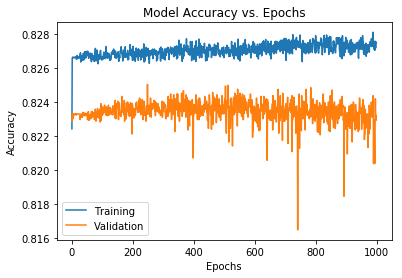

In [23]:
# plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy vs. Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc = 'best')
plt.show()

In [55]:
binary_ann.evaluate(X_train, y_train, verbose=0) 

[0.4265898541269143, 0.82619315]

In [24]:
songs_df = pd.read_csv('data/songs_all_decade_clean.csv')

songs_df_clean = songs_df.drop(columns = ['Artist', 'Track Name', 'Track ID'])

X_train, X_test, y_train, y_test = train_test_split(songs_df_clean.loc[:, songs_df_clean.columns != 'Popularity'], 
                                                    songs_df_clean.Popularity, test_size = 0.2, 
                                                    random_state = 100)

In [25]:
# cat_cols = ['Key', 'Time Signature']
# X_train_num = X_train.drop(cat_cols, axis = 1)
# X_test_num = X_test.drop(cat_cols, axis = 1)
# num_features = X_train_num.columns.tolist()
# num_index_train = X_train.index.tolist()
# num_index_test = X_test.index.tolist()

# X_train_dum = pd.get_dummies(X_train[cat_cols], columns = cat_cols)
# X_test_dum = pd.get_dummies(X_test[cat_cols], columns = cat_cols)

# scaler = MinMaxScaler().fit(X_train_num)
# X_train_scaled = pd.DataFrame(scaler.transform(X_train_num), index = num_index_train, columns = num_features)
# X_test_scaled = pd.DataFrame(scaler.transform(X_test_num), index = num_index_test, columns = num_features)

# X_train = pd.concat([X_train_dum, X_train_scaled], axis = 1)
# X_test = pd.concat([X_test_dum, X_test_scaled], axis = 1)

cat_cols = ['Key', 'Time Signature', 'Mode']
X_train_num = X_train.drop(cat_cols, axis = 1)
X_test_num = X_test.drop(cat_cols, axis = 1)
num_features = X_train_num.columns.tolist()
num_index_train = X_train.index.tolist()
num_index_test = X_test.index.tolist()

# X_train_dum = pd.get_dummies(X_train[cat_cols], columns = cat_cols)
# X_test_dum = pd.get_dummies(X_test[cat_cols], columns = cat_cols)
X_train_dum = X_train[cat_cols]
X_test_dum = X_test[cat_cols]

scaler = MinMaxScaler().fit(X_train_num)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_num), index = num_index_train, columns = num_features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_num), index = num_index_test, columns = num_features)

X_train = pd.concat([X_train_dum, X_train_scaled], axis = 1)
X_test = pd.concat([X_test_dum, X_test_scaled], axis = 1)

In [41]:
# quantitative: ANN
# specify network layers
quant_ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation = 'sigmoid', input_shape = (13, )),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(100, activation = 'relu'),
     tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'linear')
])

# compile and fit network
quant_ann.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mean_squared_error']) 
history = quant_ann.fit(X_train, y_train, epochs = 1000, batch_size = 128, validation_split = 0.3)

Train on 49590 samples, validate on 21253 samples
Epoch 1/1000
49590/49590 [==============================] - 2s 42us/sample - loss: 296.4575 - mean_squared_error: 296.4574 - val_loss: 171.3547 - val_mean_squared_error: 171.3547
Epoch 2/1000
49590/49590 [==============================] - 2s 47us/sample - loss: 169.1547 - mean_squared_error: 169.1546 - val_loss: 166.5109 - val_mean_squared_error: 166.5109
Epoch 3/1000
49590/49590 [==============================] - 2s 34us/sample - loss: 165.9703 - mean_squared_error: 165.9703 - val_loss: 165.3780 - val_mean_squared_error: 165.3781
Epoch 4/1000
49590/49590 [==============================] - 2s 32us/sample - loss: 164.2333 - mean_squared_error: 164.2332 - val_loss: 165.3335 - val_mean_squared_error: 165.3336
Epoch 5/1000
49590/49590 [==============================] - 1s 29us/sample - loss: 163.4994 - mean_squared_error: 163.4993 - val_loss: 165.1122 - val_mean_squared_error: 165.1122
Epoch 6/1000
49590/49590 [=============================

49590/49590 [==============================] - 2s 41us/sample - loss: 144.9718 - mean_squared_error: 144.9718 - val_loss: 146.7529 - val_mean_squared_error: 146.7528
Epoch 91/1000
49590/49590 [==============================] - 2s 45us/sample - loss: 144.9027 - mean_squared_error: 144.9027 - val_loss: 146.6388 - val_mean_squared_error: 146.6389
Epoch 92/1000
49590/49590 [==============================] - 2s 43us/sample - loss: 143.9533 - mean_squared_error: 143.9533 - val_loss: 147.1598 - val_mean_squared_error: 147.1597
Epoch 93/1000
49590/49590 [==============================] - 2s 39us/sample - loss: 143.8178 - mean_squared_error: 143.8178 - val_loss: 146.0659 - val_mean_squared_error: 146.0658
Epoch 94/1000
49590/49590 [==============================] - 2s 49us/sample - loss: 143.9536 - mean_squared_error: 143.9537 - val_loss: 146.2225 - val_mean_squared_error: 146.2225
Epoch 95/1000
49590/49590 [==============================] - 2s 35us/sample - loss: 143.5499 - mean_squared_error:

49590/49590 [==============================] - 1s 29us/sample - loss: 136.9488 - mean_squared_error: 136.9488 - val_loss: 143.2055 - val_mean_squared_error: 143.2055
Epoch 181/1000
49590/49590 [==============================] - 1s 28us/sample - loss: 136.8511 - mean_squared_error: 136.8511 - val_loss: 142.6247 - val_mean_squared_error: 142.6247
Epoch 182/1000
49590/49590 [==============================] - 2s 40us/sample - loss: 136.6410 - mean_squared_error: 136.6409 - val_loss: 144.8220 - val_mean_squared_error: 144.8220
Epoch 183/1000
49590/49590 [==============================] - 2s 34us/sample - loss: 136.6266 - mean_squared_error: 136.6266 - val_loss: 144.7115 - val_mean_squared_error: 144.7115
Epoch 184/1000
49590/49590 [==============================] - 2s 31us/sample - loss: 136.9028 - mean_squared_error: 136.9029 - val_loss: 142.3721 - val_mean_squared_error: 142.3721
Epoch 185/1000
49590/49590 [==============================] - 1s 29us/sample - loss: 136.9841 - mean_squared_e

49590/49590 [==============================] - 1s 28us/sample - loss: 132.5941 - mean_squared_error: 132.5941 - val_loss: 142.0463 - val_mean_squared_error: 142.0463
Epoch 271/1000
49590/49590 [==============================] - 1s 27us/sample - loss: 132.5052 - mean_squared_error: 132.5052 - val_loss: 141.9155 - val_mean_squared_error: 141.9156
Epoch 272/1000
49590/49590 [==============================] - 1s 26us/sample - loss: 132.2899 - mean_squared_error: 132.2899 - val_loss: 141.7361 - val_mean_squared_error: 141.7361
Epoch 273/1000
49590/49590 [==============================] - 1s 27us/sample - loss: 132.0030 - mean_squared_error: 132.0031 - val_loss: 142.5364 - val_mean_squared_error: 142.5364
Epoch 274/1000
49590/49590 [==============================] - 1s 27us/sample - loss: 131.9778 - mean_squared_error: 131.9778 - val_loss: 141.9124 - val_mean_squared_error: 141.9124
Epoch 275/1000
49590/49590 [==============================] - 1s 26us/sample - loss: 132.3955 - mean_squared_e

49590/49590 [==============================] - 2s 30us/sample - loss: 128.0028 - mean_squared_error: 128.0028 - val_loss: 145.0707 - val_mean_squared_error: 145.0707
Epoch 361/1000
49590/49590 [==============================] - 1s 27us/sample - loss: 127.8482 - mean_squared_error: 127.8482 - val_loss: 144.5542 - val_mean_squared_error: 144.5542
Epoch 362/1000
49590/49590 [==============================] - 1s 28us/sample - loss: 127.8641 - mean_squared_error: 127.8641 - val_loss: 144.2421 - val_mean_squared_error: 144.2421
Epoch 363/1000
49590/49590 [==============================] - 2s 33us/sample - loss: 127.6900 - mean_squared_error: 127.6899 - val_loss: 147.2797 - val_mean_squared_error: 147.2798
Epoch 364/1000
49590/49590 [==============================] - 1s 29us/sample - loss: 127.5717 - mean_squared_error: 127.5717 - val_loss: 146.7247 - val_mean_squared_error: 146.7247
Epoch 365/1000
49590/49590 [==============================] - 1s 28us/sample - loss: 127.2105 - mean_squared_e

49590/49590 [==============================] - 1s 28us/sample - loss: 123.1682 - mean_squared_error: 123.1682 - val_loss: 149.1330 - val_mean_squared_error: 149.1330
Epoch 451/1000
49590/49590 [==============================] - 1s 28us/sample - loss: 122.8955 - mean_squared_error: 122.8955 - val_loss: 147.8614 - val_mean_squared_error: 147.8613
Epoch 452/1000
49590/49590 [==============================] - 1s 28us/sample - loss: 123.0204 - mean_squared_error: 123.0204 - val_loss: 147.6934 - val_mean_squared_error: 147.6934
Epoch 453/1000
49590/49590 [==============================] - 1s 29us/sample - loss: 123.2802 - mean_squared_error: 123.2803 - val_loss: 151.2622 - val_mean_squared_error: 151.2622
Epoch 454/1000
49590/49590 [==============================] - 1s 29us/sample - loss: 123.0849 - mean_squared_error: 123.0848 - val_loss: 148.1669 - val_mean_squared_error: 148.1668
Epoch 455/1000
49590/49590 [==============================] - 1s 28us/sample - loss: 122.8855 - mean_squared_e

49590/49590 [==============================] - 1s 30us/sample - loss: 118.4335 - mean_squared_error: 118.4335 - val_loss: 151.1965 - val_mean_squared_error: 151.1965
Epoch 541/1000
49590/49590 [==============================] - 1s 29us/sample - loss: 118.6753 - mean_squared_error: 118.6752 - val_loss: 152.4501 - val_mean_squared_error: 152.4501
Epoch 542/1000
49590/49590 [==============================] - 1s 29us/sample - loss: 118.8654 - mean_squared_error: 118.8654 - val_loss: 150.8341 - val_mean_squared_error: 150.8341
Epoch 543/1000
49590/49590 [==============================] - 1s 28us/sample - loss: 118.6550 - mean_squared_error: 118.6550 - val_loss: 151.0391 - val_mean_squared_error: 151.0391
Epoch 544/1000
49590/49590 [==============================] - 1s 29us/sample - loss: 119.0155 - mean_squared_error: 119.0155 - val_loss: 151.1912 - val_mean_squared_error: 151.1913
Epoch 545/1000
49590/49590 [==============================] - 1s 29us/sample - loss: 118.8968 - mean_squared_e

49590/49590 [==============================] - 1s 30us/sample - loss: 115.2593 - mean_squared_error: 115.2592 - val_loss: 153.1487 - val_mean_squared_error: 153.1487
Epoch 631/1000
49590/49590 [==============================] - 1s 28us/sample - loss: 115.3801 - mean_squared_error: 115.3800 - val_loss: 153.5916 - val_mean_squared_error: 153.5916
Epoch 632/1000
49590/49590 [==============================] - 1s 29us/sample - loss: 115.5076 - mean_squared_error: 115.5076 - val_loss: 155.9644 - val_mean_squared_error: 155.9644
Epoch 633/1000
49590/49590 [==============================] - 1s 29us/sample - loss: 115.1516 - mean_squared_error: 115.1516 - val_loss: 153.4402 - val_mean_squared_error: 153.4402
Epoch 634/1000
49590/49590 [==============================] - 1s 28us/sample - loss: 115.2914 - mean_squared_error: 115.2913 - val_loss: 153.5923 - val_mean_squared_error: 153.5923
Epoch 635/1000
49590/49590 [==============================] - 1s 28us/sample - loss: 115.3194 - mean_squared_e

49590/49590 [==============================] - 2s 32us/sample - loss: 112.2102 - mean_squared_error: 112.2102 - val_loss: 155.9264 - val_mean_squared_error: 155.9264
Epoch 721/1000
49590/49590 [==============================] - 2s 42us/sample - loss: 112.5695 - mean_squared_error: 112.5695 - val_loss: 155.2111 - val_mean_squared_error: 155.2112
Epoch 722/1000
49590/49590 [==============================] - 3s 56us/sample - loss: 112.9998 - mean_squared_error: 112.9998 - val_loss: 160.8412 - val_mean_squared_error: 160.8411
Epoch 723/1000
49590/49590 [==============================] - 3s 52us/sample - loss: 112.5350 - mean_squared_error: 112.5350 - val_loss: 157.5534 - val_mean_squared_error: 157.5534
Epoch 724/1000
49590/49590 [==============================] - 3s 61us/sample - loss: 112.3424 - mean_squared_error: 112.3424 - val_loss: 158.1206 - val_mean_squared_error: 158.1206
Epoch 725/1000
49590/49590 [==============================] - 2s 49us/sample - loss: 112.6607 - mean_squared_e

49590/49590 [==============================] - 2s 31us/sample - loss: 110.0869 - mean_squared_error: 110.0869 - val_loss: 159.9101 - val_mean_squared_error: 159.9101
Epoch 811/1000
49590/49590 [==============================] - 1s 29us/sample - loss: 110.2300 - mean_squared_error: 110.2300 - val_loss: 159.2744 - val_mean_squared_error: 159.2744
Epoch 812/1000
49590/49590 [==============================] - 2s 32us/sample - loss: 110.1649 - mean_squared_error: 110.1648 - val_loss: 159.6544 - val_mean_squared_error: 159.6544
Epoch 813/1000
49590/49590 [==============================] - 2s 37us/sample - loss: 109.8957 - mean_squared_error: 109.8958 - val_loss: 159.4759 - val_mean_squared_error: 159.4759
Epoch 814/1000
49590/49590 [==============================] - 2s 33us/sample - loss: 109.9124 - mean_squared_error: 109.9124 - val_loss: 161.0306 - val_mean_squared_error: 161.0305
Epoch 815/1000
49590/49590 [==============================] - 2s 41us/sample - loss: 110.0605 - mean_squared_e

49590/49590 [==============================] - 1s 26us/sample - loss: 107.8454 - mean_squared_error: 107.8453 - val_loss: 162.5667 - val_mean_squared_error: 162.5666
Epoch 901/1000
49590/49590 [==============================] - 1s 26us/sample - loss: 107.6933 - mean_squared_error: 107.6933 - val_loss: 163.5745 - val_mean_squared_error: 163.5746
Epoch 902/1000
49590/49590 [==============================] - 1s 26us/sample - loss: 108.1160 - mean_squared_error: 108.1160 - val_loss: 165.0274 - val_mean_squared_error: 165.0275
Epoch 903/1000
49590/49590 [==============================] - 1s 26us/sample - loss: 108.0837 - mean_squared_error: 108.0837 - val_loss: 161.9187 - val_mean_squared_error: 161.9187
Epoch 904/1000
49590/49590 [==============================] - 1s 25us/sample - loss: 107.7342 - mean_squared_error: 107.7342 - val_loss: 162.2512 - val_mean_squared_error: 162.2512
Epoch 905/1000
49590/49590 [==============================] - 1s 26us/sample - loss: 108.1244 - mean_squared_e

49590/49590 [==============================] - 2s 36us/sample - loss: 106.2853 - mean_squared_error: 106.2852 - val_loss: 165.3404 - val_mean_squared_error: 165.3403
Epoch 991/1000
49590/49590 [==============================] - 2s 31us/sample - loss: 105.8487 - mean_squared_error: 105.8487 - val_loss: 163.2117 - val_mean_squared_error: 163.2117
Epoch 992/1000
49590/49590 [==============================] - 2s 32us/sample - loss: 106.0548 - mean_squared_error: 106.0548 - val_loss: 167.3422 - val_mean_squared_error: 167.3421
Epoch 993/1000
49590/49590 [==============================] - 2s 32us/sample - loss: 106.4812 - mean_squared_error: 106.4812 - val_loss: 166.2791 - val_mean_squared_error: 166.2791
Epoch 994/1000
49590/49590 [==============================] - 1s 30us/sample - loss: 105.8399 - mean_squared_error: 105.8399 - val_loss: 165.7945 - val_mean_squared_error: 165.7945
Epoch 995/1000
49590/49590 [==============================] - 1s 28us/sample - loss: 106.5316 - mean_squared_e

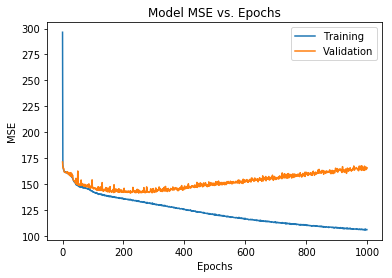

In [42]:
# plot training and validation accuracy
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model MSE vs. Epochs')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc = 'best')
plt.show()

In [45]:
scores = quant_ann.predict(X_test)
accuracy = r2_score(y_test, scores)
print(accuracy)

0.0862026946720178


In [32]:
# quantitative: ANN
# specify network layers
quant_ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation = 'sigmoid', input_shape = (13, )),
    tf.keras.layers.Dense(100, activation = 'relu', 
                       kernel_regularizer = tf.keras.regularizers.l2(l = 0.001)),
    tf.keras.layers.Dense(1, activation = 'linear')
])

# compile and fit network
quant_ann.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mean_squared_error']) 
history = quant_ann.fit(X_train, y_train, epochs = 1000, batch_size = 128, validation_split = 0.3)

Train on 49590 samples, validate on 21253 samples
Epoch 1/1000
49590/49590 [==============================] - 1s 30us/sample - loss: 390.1971 - mean_squared_error: 390.1010 - val_loss: 172.8463 - val_mean_squared_error: 172.7507
Epoch 2/1000
49590/49590 [==============================] - 1s 25us/sample - loss: 170.4170 - mean_squared_error: 170.3210 - val_loss: 168.8234 - val_mean_squared_error: 168.7268
Epoch 3/1000
49590/49590 [==============================] - 1s 26us/sample - loss: 167.4288 - mean_squared_error: 167.3316 - val_loss: 166.7804 - val_mean_squared_error: 166.6817
Epoch 4/1000
49590/49590 [==============================] - 1s 24us/sample - loss: 165.3487 - mean_squared_error: 165.2495 - val_loss: 164.8314 - val_mean_squared_error: 164.7315
Epoch 5/1000
49590/49590 [==============================] - 1s 28us/sample - loss: 163.7816 - mean_squared_error: 163.6806 - val_loss: 164.2961 - val_mean_squared_error: 164.1937
Epoch 6/1000
49590/49590 [=============================

49590/49590 [==============================] - 1s 21us/sample - loss: 151.1740 - mean_squared_error: 150.9695 - val_loss: 152.1652 - val_mean_squared_error: 151.9585
Epoch 91/1000
49590/49590 [==============================] - 1s 21us/sample - loss: 150.8619 - mean_squared_error: 150.6541 - val_loss: 151.8693 - val_mean_squared_error: 151.6597
Epoch 92/1000
49590/49590 [==============================] - 1s 21us/sample - loss: 150.8623 - mean_squared_error: 150.6512 - val_loss: 152.3916 - val_mean_squared_error: 152.1794
Epoch 93/1000
49590/49590 [==============================] - 1s 21us/sample - loss: 150.7115 - mean_squared_error: 150.4977 - val_loss: 152.0321 - val_mean_squared_error: 151.8157
Epoch 94/1000
49590/49590 [==============================] - 1s 21us/sample - loss: 150.4783 - mean_squared_error: 150.2610 - val_loss: 151.7154 - val_mean_squared_error: 151.4967
Epoch 95/1000
49590/49590 [==============================] - 1s 21us/sample - loss: 150.6644 - mean_squared_error:

49590/49590 [==============================] - 1s 19us/sample - loss: 145.1452 - mean_squared_error: 144.7484 - val_loss: 147.7131 - val_mean_squared_error: 147.3156
Epoch 181/1000
49590/49590 [==============================] - 1s 19us/sample - loss: 145.2570 - mean_squared_error: 144.8590 - val_loss: 148.6815 - val_mean_squared_error: 148.2836
Epoch 182/1000
49590/49590 [==============================] - 1s 19us/sample - loss: 145.2212 - mean_squared_error: 144.8220 - val_loss: 148.1326 - val_mean_squared_error: 147.7348
Epoch 183/1000
49590/49590 [==============================] - 1s 27us/sample - loss: 145.1040 - mean_squared_error: 144.7036 - val_loss: 147.7145 - val_mean_squared_error: 147.3159
Epoch 184/1000
49590/49590 [==============================] - 1s 27us/sample - loss: 145.1943 - mean_squared_error: 144.7952 - val_loss: 147.5855 - val_mean_squared_error: 147.1853
Epoch 185/1000
49590/49590 [==============================] - 2s 31us/sample - loss: 145.0292 - mean_squared_e

49590/49590 [==============================] - 1s 19us/sample - loss: 142.4402 - mean_squared_error: 141.9631 - val_loss: 146.7618 - val_mean_squared_error: 146.2859
Epoch 271/1000
49590/49590 [==============================] - 1s 23us/sample - loss: 142.4606 - mean_squared_error: 141.9839 - val_loss: 145.6525 - val_mean_squared_error: 145.1755
Epoch 272/1000
49590/49590 [==============================] - 1s 19us/sample - loss: 142.1351 - mean_squared_error: 141.6585 - val_loss: 146.1459 - val_mean_squared_error: 145.6672
Epoch 273/1000
49590/49590 [==============================] - 1s 22us/sample - loss: 142.1717 - mean_squared_error: 141.6930 - val_loss: 145.7996 - val_mean_squared_error: 145.3223
Epoch 274/1000
49590/49590 [==============================] - 1s 23us/sample - loss: 142.3207 - mean_squared_error: 141.8422 - val_loss: 147.5208 - val_mean_squared_error: 147.0422
Epoch 275/1000
49590/49590 [==============================] - 1s 24us/sample - loss: 142.2447 - mean_squared_e

49590/49590 [==============================] - 2s 33us/sample - loss: 140.4065 - mean_squared_error: 139.8913 - val_loss: 144.8226 - val_mean_squared_error: 144.3075
Epoch 361/1000
49590/49590 [==============================] - 1s 27us/sample - loss: 140.4284 - mean_squared_error: 139.9140 - val_loss: 144.2745 - val_mean_squared_error: 143.7588
Epoch 362/1000
49590/49590 [==============================] - 1s 23us/sample - loss: 140.3603 - mean_squared_error: 139.8438 - val_loss: 144.9376 - val_mean_squared_error: 144.4215
Epoch 363/1000
49590/49590 [==============================] - 1s 22us/sample - loss: 140.2687 - mean_squared_error: 139.7529 - val_loss: 144.1742 - val_mean_squared_error: 143.6573
Epoch 364/1000
49590/49590 [==============================] - 2s 34us/sample - loss: 140.3764 - mean_squared_error: 139.8592 - val_loss: 144.5480 - val_mean_squared_error: 144.0320
Epoch 365/1000
49590/49590 [==============================] - 1s 30us/sample - loss: 140.3626 - mean_squared_e

49590/49590 [==============================] - 1s 23us/sample - loss: 139.2494 - mean_squared_error: 138.7294 - val_loss: 143.6235 - val_mean_squared_error: 143.1017
Epoch 451/1000
49590/49590 [==============================] - 1s 21us/sample - loss: 139.0859 - mean_squared_error: 138.5646 - val_loss: 143.5855 - val_mean_squared_error: 143.0642
Epoch 452/1000
49590/49590 [==============================] - 1s 25us/sample - loss: 139.0872 - mean_squared_error: 138.5658 - val_loss: 144.7865 - val_mean_squared_error: 144.2648
Epoch 453/1000
49590/49590 [==============================] - 2s 34us/sample - loss: 138.9549 - mean_squared_error: 138.4348 - val_loss: 143.8265 - val_mean_squared_error: 143.3042
Epoch 454/1000
49590/49590 [==============================] - 1s 28us/sample - loss: 139.0347 - mean_squared_error: 138.5137 - val_loss: 144.3162 - val_mean_squared_error: 143.7953
Epoch 455/1000
49590/49590 [==============================] - 1s 23us/sample - loss: 138.9395 - mean_squared_e

49590/49590 [==============================] - 1s 20us/sample - loss: 138.1644 - mean_squared_error: 137.6361 - val_loss: 144.3446 - val_mean_squared_error: 143.8185
Epoch 541/1000
49590/49590 [==============================] - 1s 23us/sample - loss: 138.0576 - mean_squared_error: 137.5305 - val_loss: 143.6584 - val_mean_squared_error: 143.1318
Epoch 542/1000
49590/49590 [==============================] - 1s 20us/sample - loss: 138.2181 - mean_squared_error: 137.6922 - val_loss: 142.9577 - val_mean_squared_error: 142.4315
Epoch 543/1000
49590/49590 [==============================] - 1s 22us/sample - loss: 138.1188 - mean_squared_error: 137.5923 - val_loss: 143.0766 - val_mean_squared_error: 142.5494
Epoch 544/1000
49590/49590 [==============================] - 1s 20us/sample - loss: 138.1706 - mean_squared_error: 137.6433 - val_loss: 148.4618 - val_mean_squared_error: 147.9347
Epoch 545/1000
49590/49590 [==============================] - 1s 26us/sample - loss: 138.3124 - mean_squared_e

49590/49590 [==============================] - 1s 20us/sample - loss: 137.4503 - mean_squared_error: 136.9177 - val_loss: 142.9508 - val_mean_squared_error: 142.4185
Epoch 631/1000
49590/49590 [==============================] - 1s 19us/sample - loss: 137.5736 - mean_squared_error: 137.0403 - val_loss: 142.9761 - val_mean_squared_error: 142.4437
Epoch 632/1000
49590/49590 [==============================] - 1s 19us/sample - loss: 137.2444 - mean_squared_error: 136.7113 - val_loss: 143.5671 - val_mean_squared_error: 143.0341
Epoch 633/1000
49590/49590 [==============================] - 1s 20us/sample - loss: 137.5336 - mean_squared_error: 137.0020 - val_loss: 143.0699 - val_mean_squared_error: 142.5378
Epoch 634/1000
49590/49590 [==============================] - 1s 19us/sample - loss: 137.0952 - mean_squared_error: 136.5627 - val_loss: 142.6910 - val_mean_squared_error: 142.1583
Epoch 635/1000
49590/49590 [==============================] - 1s 19us/sample - loss: 137.5006 - mean_squared_e

49590/49590 [==============================] - 1s 30us/sample - loss: 136.6879 - mean_squared_error: 136.1525 - val_loss: 142.9806 - val_mean_squared_error: 142.4466
Epoch 721/1000
49590/49590 [==============================] - 1s 25us/sample - loss: 136.6133 - mean_squared_error: 136.0779 - val_loss: 142.5359 - val_mean_squared_error: 142.0016
Epoch 722/1000
49590/49590 [==============================] - 2s 39us/sample - loss: 136.6608 - mean_squared_error: 136.1265 - val_loss: 143.0602 - val_mean_squared_error: 142.5273
Epoch 723/1000
49590/49590 [==============================] - 1s 30us/sample - loss: 136.5510 - mean_squared_error: 136.0167 - val_loss: 143.1618 - val_mean_squared_error: 142.6270
Epoch 724/1000
49590/49590 [==============================] - 2s 33us/sample - loss: 136.7528 - mean_squared_error: 136.2176 - val_loss: 144.2431 - val_mean_squared_error: 143.7100
Epoch 725/1000
49590/49590 [==============================] - 1s 25us/sample - loss: 136.6491 - mean_squared_e

49590/49590 [==============================] - 1s 25us/sample - loss: 136.0970 - mean_squared_error: 135.5640 - val_loss: 143.1919 - val_mean_squared_error: 142.6597
Epoch 811/1000
49590/49590 [==============================] - 1s 24us/sample - loss: 135.8869 - mean_squared_error: 135.3536 - val_loss: 142.5320 - val_mean_squared_error: 141.9991
Epoch 812/1000
49590/49590 [==============================] - 1s 30us/sample - loss: 136.1675 - mean_squared_error: 135.6350 - val_loss: 142.8629 - val_mean_squared_error: 142.3293
Epoch 813/1000
49590/49590 [==============================] - 1s 23us/sample - loss: 135.9333 - mean_squared_error: 135.4007 - val_loss: 142.8223 - val_mean_squared_error: 142.2881
Epoch 814/1000
49590/49590 [==============================] - 2s 35us/sample - loss: 136.1132 - mean_squared_error: 135.5788 - val_loss: 143.3900 - val_mean_squared_error: 142.8568
Epoch 815/1000
49590/49590 [==============================] - 2s 35us/sample - loss: 136.0054 - mean_squared_e

49590/49590 [==============================] - 1s 24us/sample - loss: 135.5250 - mean_squared_error: 134.9938 - val_loss: 142.7989 - val_mean_squared_error: 142.2672
Epoch 901/1000
49590/49590 [==============================] - 2s 37us/sample - loss: 135.5819 - mean_squared_error: 135.0507 - val_loss: 142.5050 - val_mean_squared_error: 141.9742
Epoch 902/1000
49590/49590 [==============================] - 2s 34us/sample - loss: 135.4234 - mean_squared_error: 134.8925 - val_loss: 142.2314 - val_mean_squared_error: 141.7016
Epoch 903/1000
49590/49590 [==============================] - 2s 37us/sample - loss: 135.4216 - mean_squared_error: 134.8901 - val_loss: 142.9416 - val_mean_squared_error: 142.4113
Epoch 904/1000
49590/49590 [==============================] - 2s 32us/sample - loss: 135.3582 - mean_squared_error: 134.8279 - val_loss: 142.3344 - val_mean_squared_error: 141.8034
Epoch 905/1000
49590/49590 [==============================] - 1s 30us/sample - loss: 135.6388 - mean_squared_e

49590/49590 [==============================] - 1s 27us/sample - loss: 134.9406 - mean_squared_error: 134.4068 - val_loss: 142.1848 - val_mean_squared_error: 141.6510
Epoch 991/1000
49590/49590 [==============================] - 2s 31us/sample - loss: 135.1471 - mean_squared_error: 134.6134 - val_loss: 143.9145 - val_mean_squared_error: 143.3801
Epoch 992/1000
49590/49590 [==============================] - 2s 32us/sample - loss: 134.9861 - mean_squared_error: 134.4531 - val_loss: 143.0095 - val_mean_squared_error: 142.4748
Epoch 993/1000
49590/49590 [==============================] - 1s 25us/sample - loss: 135.0379 - mean_squared_error: 134.5041 - val_loss: 142.2115 - val_mean_squared_error: 141.6775
Epoch 994/1000
49590/49590 [==============================] - 1s 29us/sample - loss: 135.0702 - mean_squared_error: 134.5367 - val_loss: 143.0097 - val_mean_squared_error: 142.4754
Epoch 995/1000
49590/49590 [==============================] - 2s 33us/sample - loss: 134.7591 - mean_squared_e

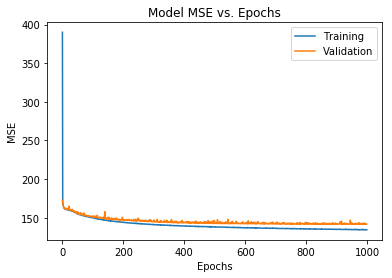

In [35]:
# plot training and validation accuracy
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model MSE vs. Epochs')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc = 'best')
plt.show()

In [40]:
from sklearn.metrics import r2_score

scores = quant_ann.predict(X_train)
accuracy = r2_score(y_train, scores)
print(accuracy)

0.22432744545591743


In [4]:
oldies = pd.read_csv("data/oldies.csv")

In [5]:
oldies

,Artist,Track Name,Track ID,Popularity,Acousticness,Danceability,Duration_ms,Energy,Instrumentalness,Key,Liveness,Loudness,Mode,Speechiness,Tempo,Time Signature,Valence
0,Elton John,"Rocket Man (I Think It's Going To Be A Long, L...",3gdewACMIVMEWVbyb8O9sY,83,0.43200,0.601,281613,0.532,0.000006,10,0.0925,-9.119,1,0.0286,136.571,4,0.341
1,Stevie Wonder,Isn't She Lovely,3vqlZUIT3rEmLaYKDBfb4Q,18,0.18000,0.485,394267,0.820,0.004110,1,0.3280,-6.887,0,0.0953,118.643,4,0.817
2,The Doobie Brothers,Listen to the Music,7Ar4G7Ci11gpt6sfH9Cgz5,76,0.22100,0.645,227267,0.598,0.000004,1,0.0721,-13.180,0,0.0335,105.929,4,0.913
3,Van Morrison,Moondance - 2013 Remaster,683b4ikwa62JevCjwrmfg6,69,0.50100,0.606,274040,0.282,0.000008,9,0.1520,-12.207,0,0.0339,67.409,4,0.563
4,The Bellamy Brothers,Let Your Love Flow,064SVQsmWl5EF0zahmzkQk,69,0.06110,0.679,198760,0.553,0.000007,3,0.1390,-14.687,1,0.0316,109.071,4,0.946
5,Elton John,Don't Go Breaking My Heart,7HW5WIw7ZgZORCzUxv5gW5,77,0.14900,0.729,275440,0.844,0.000003,5,0.0604,-8.824,1,0.0344,131.459,4,0.777
6,Carly Simon,You're so Vain,2DnJjbjNTV9Nd5NOa1KGba,76,0.15700,0.659,258411,0.678,0.000007,0,0.0784,-8.180,1,0.0313,106.186,4,0.647
7,Commodores,Easy,1JQ6Xm1JrvHfvAqhl5pwaA,77,0.11200,0.589,256427,0.384,0.000028,10,0.0596,-15.075,0,0.0332,132.909,4,0.354
8,Don McLean,American Pie,1fDsrQ23eTAVFElUMaf38X,75,0.69900,0.531,516893,0.481,0.000000,4,0.0842,-11.709,0,0.0600,138.450,4,0.491
9,Electric Light Orchestra,Livin' Thing,2hdNya0b6Cc2YJ8IyaQIWp,71,0.58300,0.549,212307,0.651,0.000000,0,0.1210,-7.097,1,0.0323,122.818,4,0.368


In [ ]:
bag_reg = BaggingRegressor(n_estimators=10, random_state=0).fit(X_train_2, y_train_2)

bag_reg_train_score = bag_reg.score(X_train_2, y_train_2)
print('R^2 on training set:', bag_reg_train_score)

bag_reg_test_score = bag_reg.score(X_test_2, y_test_2)
print('R^2 on test set:', bag_reg_test_score)